In [1]:
import sys
sys.path.append('../')
sys.path.insert(0, '../terrace')

%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
import rdkit
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from common.cfg_utils import get_config
from common.metrics import *
from common.losses import *
from common.cfg_utils import *
from common.old_routine import *
from datasets.make_dataset import *
from models.gnn_bind import *
from models.learnable_ff import LearnableFF
from routines.ai_routine import *
from terrace.batch import *
from terrace.type_data import *
from terrace.comp_node import *
from torchmetrics import *
from datasets.data_types import *
from models.val_model import *
from datasets.bigbind_screen import *
from common.cache import *
from glob import glob
import wandb
from git_timewarp import GitTimeWarp

In [11]:
cfg = get_config("../configs", "short_thicc_op_gnn")
cfg.data.sna_frac = 1
cfg.data.cache = False
cfg.data.use_rec = True
cfg.data.use_lig = False
loader = make_dataloader(cfg, "val")
in_node = Input(loader.get_type_data())
len(loader.dataset[1000].lig.ndata)

28

In [8]:
mol = Chem.MolFromSmiles(loader.dataset.activities.lig_smiles[0])
Chem.Draw.MolToFile(mol, "../outputs/ex_mol.png")

In [13]:
targ = BigBindScreenDataset.get_all_targets(cfg, "val")[0]
dataset = BigBindScreenDataset(cfg, targ, "val")

In [18]:
model = VinaModel(cfg)
vals = []
for d in dataset:
    b = make_batch([d])
    vals.append(model(b, dataset))

In [21]:
sorted(vals, key=lambda x: -x)

[tensor([10.8000]),
 tensor([10.3000]),
 tensor([10.1000]),
 tensor([10.]),
 tensor([9.9000]),
 tensor([9.8000]),
 tensor([9.8000]),
 tensor([9.8000]),
 tensor([9.8000]),
 tensor([9.7000]),
 tensor([9.7000]),
 tensor([9.7000]),
 tensor([9.6000]),
 tensor([9.6000]),
 tensor([9.6000]),
 tensor([9.6000]),
 tensor([9.5000]),
 tensor([9.5000]),
 tensor([9.4000]),
 tensor([9.4000]),
 tensor([9.4000]),
 tensor([9.4000]),
 tensor([9.4000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.3000]),
 tensor([9.2000]),
 tensor([9.2000]),
 tensor([9.2000]),
 tensor([9.2000]),
 tensor([9.2000]),
 tensor([9.1000]),
 tensor([9.1000]),
 tensor([9.1000]),
 tensor([9.1000]),
 tensor([9.1000]),
 tensor([9.1000]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([9.]),
 tensor([8.9000]),

In [7]:
api = wandb.Api()
run_id = "1nhqz8vw"
run = api.run(f"{cfg.project}/{run_id}")

In [9]:
artifact = get_weight_artifact(run)
out_filename = f"../outputs/lit_pca_results_{run_id}_{artifact.version}.csv"

In [13]:
df = pd.read_csv(out_filename)

In [58]:
df = df.sort_values(by="EF1%", ascending=False)

NameError: name 'df' is not defined

In [58]:
prior_lit_pcba = pd.read_csv("../prior_work/lit_pcba.csv")
prior_lit_pcba = prior_lit_pcba.set_index("target")

In [56]:
name2csv = {
    "e2ebind": "../outputs/val_screen_1nhqz8vw_v0.csv",
    "vina": "../outputs/val_screen_vina.csv",
}

In [64]:
sorted_df.query("`total actives in set` > 1")

,acc,bal_acc,auroc,precision,EF1%,NEF1%,total in set,total chosen,total actives chosen,total actives in set
target,,,,,,,,,,
ARGI1_RAT_4_321_0,0.921000,0.860804,0.935477,0.048780,40.000000,0.400000,1000,10,2,5
NR1I3_MOUSE_114_358_0,0.927000,0.963390,0.977265,0.039474,33.333332,0.333333,1000,10,1,3
CAH7_HUMAN_2_263_0,0.801000,0.899495,0.962626,0.047847,30.000002,0.300000,1000,10,3,10
MCR_HUMAN_724_984_ligBind_0,0.729000,0.863131,0.972828,0.035587,30.000002,0.300000,1000,10,3,10
CAH9_HUMAN_136_392_0,0.891892,0.945399,0.976137,0.084746,29.970003,0.300000,999,10,3,10
...,...,...,...,...,...,...,...,...,...,...
KDM4A_HUMAN_1_358_0,0.859000,0.433838,0.424141,0.000000,0.000000,0.000000,1000,10,0,10
AMD_RAT_498_820_0,0.983000,0.496465,0.425455,0.000000,0.000000,0.000000,1000,10,0,10
PLM2_PLAFA_124_453_0,0.897000,0.799495,0.853939,0.065421,0.000000,0.000000,1000,10,0,10


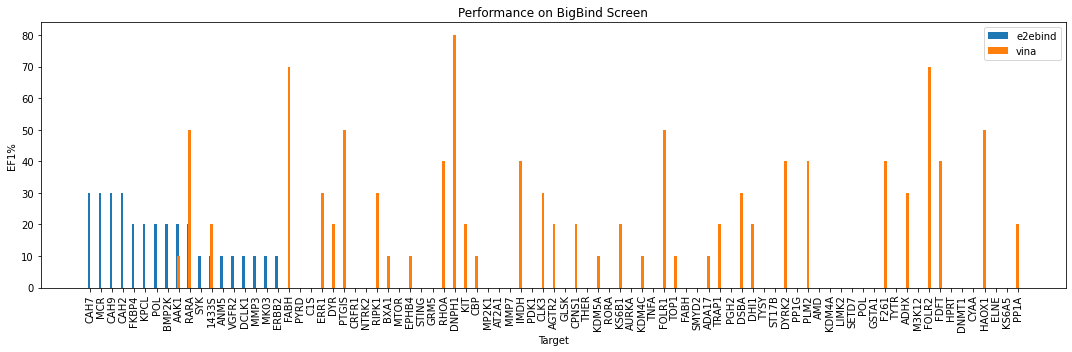

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def make_screen_fig(cfg, name2csv, sort_key="e2ebind", min_actives=10):

    name2df = {}
    for name, csv in name2csv.items():
        df = pd.read_csv(csv).set_index("target")
        df = df.query("`total actives in set` >= @min_actives")
        name2df[name] = df
    sorted_df = name2df[sort_key]
    sorted_df = sorted_df.sort_values(by="EF1%", ascending=False)

    fig, ax = plt.subplots()
    x = np.arange(len(sorted_df))
    width = 0.25

    name2ef1 = {}
    for i, (name, df) in enumerate(name2df.items()):
        ef1_scores = df["EF1%"][sorted_df.index]
        name2ef1[name] = ef1_scores
        rects = ax.bar(x + width*(i-1)/2, ef1_scores, width, label=name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('EF1%')
    ax.set_title("Performance on BigBind Screen")
    ax.set_xticks(x)
    targets = [ t.split("_")[0] for t in sorted_df.index ]
    ax.set_xticklabels(targets, rotation='vertical')
    ax.set_xlabel("Target")
    ax.legend()

    fig.set_size_inches(15, 5)
    fig.tight_layout()
    out_filename = "../outputs/val_screen_results.png"
    fig.savefig(out_filename, transparent=False)

make_screen_fig(cfg, name2csv)

In [145]:
run_ids = ["1nhqz8vw", "1socj7qg" ]
name2model = {}
api = wandb.Api()
for run_id in run_ids:
    run = api.run(f"{cfg.project}/{run_id}") # wandb.init(project=cfg.project, id=run_id, resume=True)
    cfg = get_run_config(run, cfg)
    artifact = api.artifact(f"{cfg.project}/model-{run.id}:latest", type='model')
    artifact_dir = artifact.download()
    checkpoint_file = artifact_dir + "/model.ckpt"
    routine = AIRoutine.from_checkpoint(cfg, checkpoint_file)
    name2model[run.name] = routine.model

/home/boris/miniconda3/envs/chem/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/boris/miniconda3/envs/chem/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
wandb: Downloading large artifact model-1nhqz8vw:latest, 207.47MB. 1 files... Done. 0:0:0
/home/boris/miniconda3/envs/chem/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
wandb: Downloading large artifact model-1socj7qg:latest, 207.47MB. 1 files... Done. 0:0:0
/home/boris/mini

In [163]:
import pandas as pd
from glob import glob
from datasets.graphs.mol_graph import MolGraph, mol_graph_from_sdf
from datasets.graphs.prot_graph import ProtGraph, prot_graph_from_pdb
from datasets.data_types import ActivityData, IsActiveData
from terrace.batch import make_batch

for screen_csv in glob(cfg.platform.bigbind_dir + "/val_screens/*.csv"):
    screen_df = pd.read_csv(screen_csv)
    break

In [165]:
batch_size = 16
batch_arr = []
for i, row in tqdm(screen_df.iterrows()):
    lig_file = cfg.platform.bigbind_dir + "/" + row.lig_file
    rec_file = cfg.platform.bigbind_dir + "/" + row.ex_rec_file
    lig_graph = mol_graph_from_sdf(cfg, lig_file)
    rec_graph = prot_graph_from_pdb(cfg, rec_file)
    is_active = torch.tensor(row.active, dtype=bool)
    data = IsActiveData(lig_graph, rec_graph, is_active)
    batch_arr.append(data)
    if i == batch_size:
        break

16it [00:22,  1.41s/it]


In [166]:
batch = make_batch(batch_arr)

In [167]:
for name, model in name2model.items():
    print(name, model(batch))

: 

: 

In [8]:
batch = next(iter(loader))

In [9]:
model = make_model(cfg, in_node)

In [19]:
outputs = model(batch)
norm_outs = torch.sigmoid(outputs)
print(outputs)
print(norm_outs)
print(batch.is_active)

tensor([ 0.0052, -0.0530, -0.0913,  0.0544, -0.0058, -0.0254, -0.4516, -0.3748,
        -0.4846, -0.3272, -0.4836, -0.1793, -0.4905, -0.3037, -0.4662, -0.3369],
       grad_fn=<SqueezeBackward1>)
tensor([0.5013, 0.4868, 0.4772, 0.5136, 0.4985, 0.4937, 0.3890, 0.4074, 0.3812,
        0.4189, 0.3814, 0.4553, 0.3798, 0.4247, 0.3855, 0.4166],
       grad_fn=<SigmoidBackward0>)
tensor([False, False,  True, False, False, False,  True, False,  True, False,
         True, False,  True, False,  True, False])


In [49]:
preds = (norm_outs > 0.5)
tpr = sum((preds == batch.is_active) & batch.is_active) / sum(batch.is_active)
tnr = sum((preds == batch.is_active) & ~batch.is_active) / sum(~batch.is_active)
0.5*(tpr + tnr)

tensor(0.4000)

In [58]:
for key, met in get_metrics(cfg).items():
    print(key, met(outputs, batch))

acc tensor(0.5000)
bal_acc tensor(0.4000)
auroc tensor(0.0833)


In [17]:
activities = loader.dataset.activities

In [24]:
from datasets.graphs.mol_graph import *
sdf_file = cfg.platform.bigbind_dir + "/" + activities.lig_file[0]
get_node_and_edge_nums_from_sdf(cfg, sdf_file)

(28, 30)

In [27]:
from datasets.graphs.prot_graph import *
pdb_file = cfg.platform.bigbind_dir + "/" + activities.ex_rec_file[0]
get_node_and_edge_nums_from_pdb(cfg, pdb_file)

(215, 11094)

In [52]:
from datasets.cacheable_dataset import *
cfg.platform.cache_dir + "/" + cfg.dataset + "/" + get_dataset_hash(cfg) + "/graph_sizes.csv"

'/home/boris/Data/e2ebind_cache/bigbind_act/1dd4721fe24e394c92b6dd2c6752f886/graph_sizes.csv'

In [97]:
from datasets.edge_num_sampler import *
cfg = get_config("../configs", "short_thicc_op_gnn")
sampler = EdgeNumSampler(cfg, loader.dataset)
for sample in sampler:
    print(sample)
    break

[343, 890, 75, 122, 152, 846, 82, 692, 355, 895, 304, 753, 673, 842, 308, 937, 827]


In [108]:
activities.lig_smiles.str.len().argmax()

42638

In [80]:
activities.lig_file[42638]

'chembl_structures/mol_482202.sdf'

In [64]:
for b in loader.dataset:
    print(len(b.lig.edata))

28
34
35
22
29
24
46
36
49
31
53
22
53
30
50
32
47
27
49
22
46
24
51
34
48
30
50
32
50
17
49
26
47
31
49
28
48
28
49
31
50
36
51
33
47
34
48
25
52
33
51
38
50
30
51
29
50
49
46
25
46
22
Error proccessing item at index=62
lig_file='/home/boris/Data/BigBindNew/chembl_structures/mol_3061.sdf'
rec_file='/home/boris/Data/BigBindNew/AGTR2_HUMAN_35_335_0/5unh_A_rec_pocket.pdb'


KeyboardInterrupt: 

In [11]:
b = loader.dataset[42638]
len(b.rec.edata), len(b.rec.ndata)

(2152, 51)

In [2]:
b.lig.edata.batch_size

NameError: name 'b' is not defined

In [98]:
b.lig.ndata.cat_feat

tensor([[1, 5, 2, 1, 3],
        [1, 5, 1, 0, 0],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 0, 0],
        [5, 5, 2, 1, 0],
        [3, 5, 1, 1, 0],
        [3, 5, 1, 1, 0],
        [2, 5, 2, 1, 0],
        [1, 5, 2, 1, 2],
        [1, 5, 2, 1, 2],
        [2, 5, 1, 1, 0],
        [1, 5, 2, 1, 2],
        [1, 5, 1, 0, 0],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 1, 0],
        [3, 5, 1, 1, 0],
        [1, 5, 2, 1, 1],
        [1, 5, 2, 1, 2],
        [1, 5, 2, 1, 1],
        [1, 5, 2, 1, 3],
        [1, 5, 2, 1, 3],
        [1, 5, 1, 0, 1],
        [1, 5, 1, 0, 1]])

In [13]:
for batch in loader:
    print(len(batch.lig.edata), len(batch.lig.ndata))

1254 574
1292 602
1372 635
1380 642
1354 629
1434 669
1430 659
1762 824
1872 870
1586 736
1278 586
1342 612


KeyboardInterrupt: 

In [31]:
bal_acc = Accuracy(average="macro", num_classes=2, multiclass=True)
bal_acc(norm_outs, batch.is_active)

tensor(0.4000)

In [4]:
activities = loader.dataset.activities
activities

,Unnamed: 0,lig_smiles,lig_file,uniprot,pocket,ex_rec_file,ex_rec_pdb,ex_rec_pocket_file,num_pocket_residues,pocket_center_x,pocket_center_y,pocket_center_z,pocket_size_x,pocket_size_y,pocket_size_z,active
0,0,Cc1ccc(S(=O)(=O)N2CCN(Cc3ccccc3)C(=O)[C@@H]2CC...,chembl_structures/mol_4.sdf,P08246,ELNE_HUMAN_30_247_0,ELNE_HUMAN_30_247_0/5a8x_A_rec.pdb,5a8x,ELNE_HUMAN_30_247_0/5a8x_A_rec_pocket.pdb,24,-8.5770,-3.765500,24.581500,22.676000,24.109000,24.948999,False
1,0,Cc1ccccc1Cn1ccc(NC(=O)c2cnn3c(C(F)(F)F)cc(-c4c...,chembl_structures/mol_199509.sdf,P08246,ELNE_HUMAN_30_247_0,ELNE_HUMAN_30_247_0/5a8x_A_rec.pdb,5a8x,ELNE_HUMAN_30_247_0/5a8x_A_rec_pocket.pdb,24,-8.5770,-3.765500,24.581500,22.676000,24.109000,24.948999,False
2,1,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,chembl_structures/mol_31.sdf,P04626,ERBB2_HUMAN_695_1029_0,ERBB2_HUMAN_695_1029_0/3pp0_B_rec.pdb,3pp0,ERBB2_HUMAN_695_1029_0/3pp0_B_rec_pocket.pdb,30,34.4745,42.743999,-11.703500,27.425001,22.970001,19.481000,True
3,1,Clc1ccccc1C1=Nn2c(nnc2-c2ccncc2)SC1,chembl_structures/mol_196036.sdf,P04626,ERBB2_HUMAN_695_1029_0,ERBB2_HUMAN_695_1029_0/3pp0_B_rec.pdb,3pp0,ERBB2_HUMAN_695_1029_0/3pp0_B_rec_pocket.pdb,30,34.4745,42.743999,-11.703500,27.425001,22.970001,19.481000,False
4,2,Cc1cc(C(=O)O)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F...,chembl_structures/mol_32.sdf,P04626,ERBB2_HUMAN_695_1029_0,ERBB2_HUMAN_695_1029_0/3pp0_B_rec.pdb,3pp0,ERBB2_HUMAN_695_1029_0/3pp0_B_rec_pocket.pdb,30,34.4745,42.743999,-11.703500,27.425001,22.970001,19.481000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164996,88233,CCN(CC)CCNC(=O)c1c(C)[nH]c2c1CCC/C2=C1/C(=O)Nc...,chembl_structures/mol_356378.sdf,P01375,TNFA_HUMAN_78_233_0,TNFA_HUMAN_78_233_0/2az5_A_rec.pdb,2az5,TNFA_HUMAN_78_233_0/2az5_A_rec_pocket.pdb,30,6.9700,11.006001,-39.823999,27.078000,23.450001,22.647999,False
164997,88234,C[C@@H]1CN(c2ncc(-c3ccc4c(c3)N(Cc3cccnc3C#N)C(...,chembl_structures/mol_609759.sdf,P01375,TNFA_HUMAN_78_233_0,TNFA_HUMAN_78_233_0/5m2i_A_rec.pdb,5m2i,TNFA_HUMAN_78_233_0/5m2i_A_rec_pocket.pdb,44,6.9700,11.006001,-39.823999,27.078000,23.450001,22.647999,True
164998,88234,CCOC(=S)SCC1=C(C(=O)OC(C)(C)C)N2C(=O)[C@H](OC)...,chembl_structures/mol_15905.sdf,P01375,TNFA_HUMAN_78_233_0,TNFA_HUMAN_78_233_0/5m2i_A_rec.pdb,5m2i,TNFA_HUMAN_78_233_0/5m2i_A_rec_pocket.pdb,44,6.9700,11.006001,-39.823999,27.078000,23.450001,22.647999,False
164999,88235,CC1(C)C(=O)c2ccc(-c3cnc(N4CCN5C(=O)NC[C@@H]5C4...,chembl_structures/mol_609760.sdf,P01375,TNFA_HUMAN_78_233_0,TNFA_HUMAN_78_233_0/2zjc_B_rec.pdb,2zjc,TNFA_HUMAN_78_233_0/2zjc_B_rec_pocket.pdb,44,6.9700,11.006001,-39.823999,27.078000,23.450001,22.647999,True


In [6]:
nn.ModuleDict({"train_metric": nn.Linear(10, 10)})

ModuleDict(
  (train_metric): Linear(in_features=10, out_features=10, bias=True)
)

In [11]:
dataset = make_dataset(cfg, "val")

In [12]:
sum(dataset.activities.active)/len(dataset.activities)

0.40773086223719857

In [12]:
torch.tensor(energies).var()

tensor(3721.9956)

In [16]:
from datasets.vina_score import VinaScoreDataset
dataset = VinaScoreDataset(cfg, "train")

In [65]:
(torch.randn((3,))*2).tolist()

[5.288211345672607, 2.007632255554199, 1.0654451847076416]

In [50]:
lig_file = dataset.lig_files[0]
lig = next(Chem.SDMolSupplier(lig_file, sanitize=True))
conf = lig.GetConformer()
lig_center = Chem.rdMolTransforms.ComputeCentroid(conf)
new_pos = lig_center + conf.GetAtomPosition(0)
print(conf.GetAtomPosition(0).x)
conf.SetAtomPosition(0, new_pos)
print(conf.GetAtomPosition(0).x)

-6.0803
-5.756255


In [14]:
lig = Chem.MolFromSmiles(smiles)

In [3]:
batch = next(iter(loader))

In [21]:
cfg = get_config("../configs", "outer_prod_gnn")
# cfg.model.type
model = make_model(cfg, in_node)
y_pred = model(batch)
y_pred

torch.Size([2, 4096])


tensor([0.5330, 0.2485], grad_fn=<SqueezeBackward1>)

In [8]:
cfg = get_config("../configs", "learnable_ff")
model = LearnableFF(cfg, in_node)
y_pred = model(batch)

In [10]:
get_losses(cfg, batch, y_pred)

(tensor(1031.6157, grad_fn=<AddBackward0>),
 {'coord_mse': tensor(1031.6157, grad_fn=<MeanBackward0>)})

In [79]:
torch.einsum('lf,rf->lr', lig_feat, rec_feat).shape

torch.Size([63, 54])

In [80]:
lig_feat.device

device(type='cpu')

In [77]:
rot, _ = torch.linalg.qr(torch.randn((3,3)))
trans = torch.randn(3,)
# torch.linalg.det(rand_rot)
# torch.einsum("ij,jk->ik")
coord = batch.lig.ndata.coord
trans_coord = torch.einsum('ij,bj->bi',rot,coord) + trans

In [78]:
batch_t = deepcopy(batch)
batch_t.lig.ndata.coord = trans_coord

In [43]:
(lig_coord - lig_coord.mean(0)).mean(0)

tensor([ 1.4381e-07, -4.5413e-08,  0.0000e+00])

In [39]:
lig_coord = batch.lig.ndata.coord
rec_coord = batch.rec.ndata.coord
dists = torch.zeros((lig_coord.shape[0], rec_coord.shape[0]))
for i, lc in enumerate(lig_coord):
    for j, rc in enumerate(rec_coord):
        dists[i,j] = torch.linalg.norm(lc - rc)
dists

tensor([[24.9056, 26.1221, 32.7037,  ..., 59.9716, 57.3830, 72.9151],
        [25.5268, 26.5024, 33.3077,  ..., 58.4674, 55.8833, 71.4241],
        [26.6782, 27.3604, 34.4925,  ..., 57.7209, 55.0941, 70.8719],
        ...,
        [34.9228, 35.8056, 41.8239,  ..., 46.7359, 44.6136, 58.4612],
        [35.0984, 35.6710, 42.1213,  ..., 46.3110, 44.0902, 58.4083],
        [30.1799, 31.6070, 37.5665,  ..., 54.0163, 51.6679, 66.3070]])

In [97]:
mask = torch.zeros((lig_coord.shape[0], rec_coord.shape[0]))
tot_rec = 0
tot_lig = 0
rec_graph = batch.rec.dgl_batch
lig_graph = batch.lig.dgl_batch
for r, l in zip(rec_graph.batch_num_nodes(), lig_graph.batch_num_nodes()):
    mask[tot_lig:tot_lig+l,tot_rec:tot_rec+r] = 1.0
    tot_rec += r
    tot_lig += l
mask

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [108]:
(1/(torch.cdist(lig_coord, rec_coord))**2)*mask

tensor([[0.0016, 0.0015, 0.0009,  ..., 0.0000, 0.0000, 0.0000],
        [0.0015, 0.0014, 0.0009,  ..., 0.0000, 0.0000, 0.0000],
        [0.0014, 0.0013, 0.0008,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0005, 0.0005, 0.0003],
        [0.0000, 0.0000, 0.0000,  ..., 0.0005, 0.0005, 0.0003],
        [0.0000, 0.0000, 0.0000,  ..., 0.0003, 0.0004, 0.0002]])

In [83]:
# from datasets.graphs.plot_graph import *
# plot_graph(batch_t.lig[0])

In [23]:
t1 = torch.randn((10, 100))
t2 = torch.randn((10, 50))
torch.einsum('bi,bj->bij', t1, t2).reshape((t1.size(0), -1)).shape

torch.Size([10, 5000])